# Autoencoder for Robot Joint Anomaly Detection
**Dataset:** matlab_v1.csv (Robot arm joint angles, velocities, TCP positions)

This notebook implements:
1. Data loading & preprocessing (velocity computation, normalization, noise injection)
2. Automatic latent dimension selection via PCA
3. Lightweight Autoencoder with BatchNorm
4. Training with early stopping
5. Automatic anomaly threshold selection
6. Visualization of results

In [80]:
# =============================================================================
# CELL 1: Install & Import Dependencies
# =============================================================================
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from scipy import stats

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Check GPU availability
print(f"TensorFlow version: {tf.__version__}")
print(f"GPUs available: {len(tf.config.list_physical_devices('GPU'))}")
if tf.config.list_physical_devices('GPU'):
    print(f"GPU device: {tf.config.list_physical_devices('GPU')[0]}")

TensorFlow version: 2.19.0
GPUs available: 1
GPU device: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [81]:
# =============================================================================
# CELL 2: Load Dataset from GitHub
# =============================================================================
CSV_URL = "https://raw.githubusercontent.com/AMRAli-AG/coreX/refs/heads/ai/AI/Datasets/matlab_v1.csv"

print("Loading dataset from GitHub...")
df = pd.read_csv(CSV_URL)

print(f"\n{'='*60}")
print("DATASET OVERVIEW")
print(f"{'='*60}")
print(f"Shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nData types:\n{df.dtypes}")
print(f"\nFirst 5 rows:")
df.head()

Loading dataset from GitHub...

DATASET OVERVIEW
Shape: (746, 16)

Columns: ['Time', 'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'dQ1', 'dQ2', 'dQ3', 'dQ4', 'dQ5', 'dQ6', 'TCPx', 'TCPy', 'TCPz']

Data types:
Time    float64
Q1      float64
Q2      float64
Q3      float64
Q4      float64
Q5      float64
Q6      float64
dQ1     float64
dQ2     float64
dQ3     float64
dQ4     float64
dQ5     float64
dQ6     float64
TCPx    float64
TCPy    float64
TCPz    float64
dtype: object

First 5 rows:


,Time,Q1,Q2,Q3,Q4,Q5,Q6,dQ1,dQ2,dQ3,dQ4,dQ5,dQ6,TCPx,TCPy,TCPz
0,0.00,-0.398374,-1.517280,-1.996621,-0.978158,1.091847,1.118422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.318600,0.408000,0.151400
1,0.02,-0.404068,-1.522511,-1.990484,-0.976184,1.093100,1.112164,-0.474118,-0.436266,0.512431,0.163486,0.104509,-0.520864,-0.319166,0.410938,0.152110
2,0.04,-0.409712,-1.527748,-1.984299,-0.974288,1.094357,1.105971,-0.195877,-0.184133,0.219225,0.063137,0.044333,-0.214597,-0.319731,0.413876,0.152821
3,0.06,-0.415304,-1.532990,-1.978069,-0.972469,1.095618,1.099842,-0.315074,-0.295871,0.352052,0.101892,0.071194,-0.345239,-0.320297,0.416814,0.153531
4,0.08,-0.420846,-1.538238,-1.971792,-0.970726,1.096883,1.093776,-0.260010,-0.248022,0.298019,0.079687,0.059856,-0.284325,-0.320862,0.419752,0.154241


In [82]:
# =============================================================================
# CELL 3: Preprocessing - Clean & Prepare Data
# =============================================================================

def preprocess_data(df, add_noise=True, noise_std=0.001):
    """
    Preprocess the robot joint dataset:
    1. Drop time column
    2. Ensure all numeric
    3. Compute joint velocities if missing
    4. Optionally add Gaussian noise for robustness
    """
    df_proc = df.copy()
    
    # 1. Drop time column if exists
    time_cols = [c for c in df_proc.columns if 'time' in c.lower()]
    if time_cols:
        print(f"Dropping time column(s): {time_cols}")
        df_proc = df_proc.drop(columns=time_cols)
    
    # 2. Ensure all columns are numeric
    for col in df_proc.columns:
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')
    
    # Drop rows with NaN
    initial_rows = len(df_proc)
    df_proc = df_proc.dropna()
    if len(df_proc) < initial_rows:
        print(f"Dropped {initial_rows - len(df_proc)} rows with NaN values")
    
    # 3. Check for velocity columns and compute if missing
    joint_cols = [c for c in df_proc.columns if c.startswith('Q') and 'vel' not in c.lower()]
    vel_cols = [c for c in df_proc.columns if c.startswith('dQ') and 'vel' not in c.lower()]
    
    print(f"\nJoint angle columns found: {joint_cols}")
    print(f"Velocity columns found: {vel_cols}")
    
    if len(vel_cols) == 0 and len(joint_cols) > 0:
        print("\n⚠️  No velocity columns found - computing from finite differences...")
        for jcol in joint_cols:
            vel_col_name = f"{jcol}_vel"
            # Compute velocity using finite differences (forward difference)
            df_proc[vel_col_name] = df_proc[jcol].diff().fillna(0)
        print(f"Created velocity columns: {[f'{j}_vel' for j in joint_cols]}")
    
    # 4. Optionally add small Gaussian noise for robustness
    if add_noise:
        print(f"\n🔊 Adding Gaussian noise (std={noise_std}) for robustness...")
        noise = np.random.normal(0, noise_std, df_proc.shape)
        df_proc = df_proc + noise
    
    print(f"\n✅ Final preprocessed shape: {df_proc.shape}")
    print(f"Final columns: {df_proc.columns.tolist()}")
    
    return df_proc

# Run preprocessing
df_processed = preprocess_data(df, add_noise=False, noise_std=0.001)
df_processed.head()

Dropping time column(s): ['Time']

Joint angle columns found: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6']
Velocity columns found: ['dQ1', 'dQ2', 'dQ3', 'dQ4', 'dQ5', 'dQ6']

✅ Final preprocessed shape: (746, 15)
Final columns: ['Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'dQ1', 'dQ2', 'dQ3', 'dQ4', 'dQ5', 'dQ6', 'TCPx', 'TCPy', 'TCPz']


,Q1,Q2,Q3,Q4,Q5,Q6,dQ1,dQ2,dQ3,dQ4,dQ5,dQ6,TCPx,TCPy,TCPz
0,-0.398374,-1.517280,-1.996621,-0.978158,1.091847,1.118422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.318600,0.408000,0.151400
1,-0.404068,-1.522511,-1.990484,-0.976184,1.093100,1.112164,-0.474118,-0.436266,0.512431,0.163486,0.104509,-0.520864,-0.319166,0.410938,0.152110
2,-0.409712,-1.527748,-1.984299,-0.974288,1.094357,1.105971,-0.195877,-0.184133,0.219225,0.063137,0.044333,-0.214597,-0.319731,0.413876,0.152821
3,-0.415304,-1.532990,-1.978069,-0.972469,1.095618,1.099842,-0.315074,-0.295871,0.352052,0.101892,0.071194,-0.345239,-0.320297,0.416814,0.153531
4,-0.420846,-1.538238,-1.971792,-0.970726,1.096883,1.093776,-0.260010,-0.248022,0.298019,0.079687,0.059856,-0.284325,-0.320862,0.419752,0.154241


In [83]:
# =============================================================================
# CELL 4: Train/Val Split FIRST (to avoid data leakage)
# =============================================================================

# IMPORTANT: Split BEFORE any preprocessing to avoid data leakage!
X_raw = df_processed.values

# Split data: 80% train, 20% validation
X_train_raw, X_val_raw = train_test_split(X_raw, test_size=0.2, random_state=42)

print(f"✅ Data split BEFORE normalization (no data leakage)")
print(f"Training set size: {X_train_raw.shape[0]}")
print(f"Validation set size: {X_val_raw.shape[0]}")
print(f"Feature dimension: {X_train_raw.shape[1]}")

✅ Data split BEFORE normalization (no data leakage)
Training set size: 596
Validation set size: 150
Feature dimension: 15


✅ Scaler fitted on TRAINING data only (no data leakage)

Training data - Mean: [-0. -0. -0.]...
Training data - Std: [1. 1. 1.]...
Validation data - Mean: [-0.03445  -0.063825  0.046138]...
Validation data - Std: [1.012677 0.926637 0.925511]...

PCA ANALYSIS FOR LATENT DIMENSION (on training data)
Total features: 15
Components for 95% variance: 4
📐 Selected latent dimension: 8


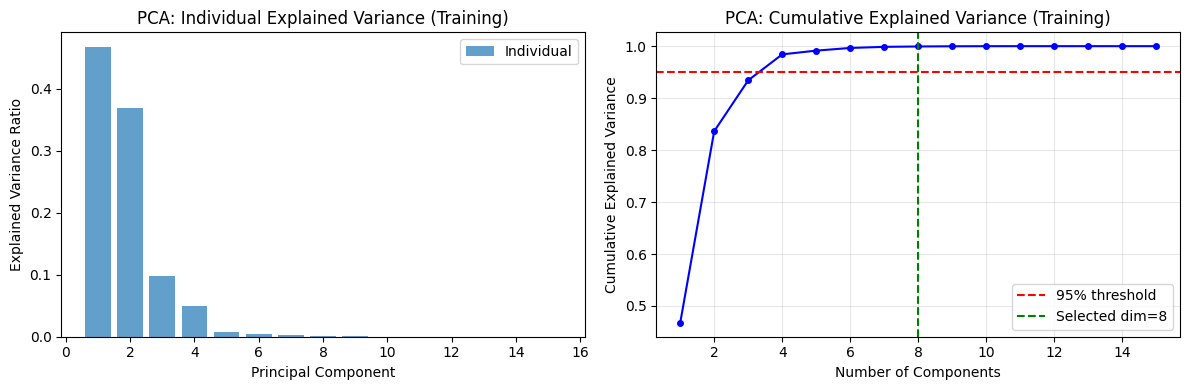

In [84]:
# =============================================================================
# CELL 5: Normalize Data (fit on TRAINING only!) & PCA Analysis
# =============================================================================

# ✅ CORRECT: Fit scaler on TRAINING data only
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_raw)  # fit + transform on training
X_val = scaler.transform(X_val_raw)          # only transform on validation

print(f"✅ Scaler fitted on TRAINING data only (no data leakage)")
print(f"\nTraining data - Mean: {X_train.mean(axis=0).round(6)[:3]}...")  
print(f"Training data - Std: {X_train.std(axis=0).round(6)[:3]}...")
print(f"Validation data - Mean: {X_val.mean(axis=0).round(6)[:3]}...")  # Won't be exactly 0
print(f"Validation data - Std: {X_val.std(axis=0).round(6)[:3]}...")    # Won't be exactly 1

# Use PCA on TRAINING data only to determine latent dimension
pca_full = PCA()
pca_full.fit(X_train)  # ✅ fit on training only

cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1

# Bound between 8 and 16
latent_dim = max(8, min(16, n_components_95))

print(f"\n{'='*60}")
print("PCA ANALYSIS FOR LATENT DIMENSION (on training data)")
print(f"{'='*60}")
print(f"Total features: {X_train.shape[1]}")
print(f"Components for 95% variance: {n_components_95}")
print(f"📐 Selected latent dimension: {latent_dim}")

# Plot explained variance
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].bar(range(1, len(pca_full.explained_variance_ratio_)+1), 
            pca_full.explained_variance_ratio_, alpha=0.7, label='Individual')
axes[0].set_xlabel('Principal Component')
axes[0].set_ylabel('Explained Variance Ratio')
axes[0].set_title('PCA: Individual Explained Variance (Training)')
axes[0].legend()

axes[1].plot(range(1, len(cumulative_variance)+1), cumulative_variance, 'b-o', markersize=4)
axes[1].axhline(y=0.95, color='r', linestyle='--', label='95% threshold')
axes[1].axvline(x=latent_dim, color='g', linestyle='--', label=f'Selected dim={latent_dim}')
axes[1].set_xlabel('Number of Components')
axes[1].set_ylabel('Cumulative Explained Variance')
axes[1].set_title('PCA: Cumulative Explained Variance (Training)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [85]:
# =============================================================================
# CELL 6: Define Autoencoder Architecture (TensorFlow/Keras)
# =============================================================================

def build_autoencoder(input_dim, latent_dim, dropout_rate=0.05):
    """
    Build a lightweight Autoencoder with BatchNorm using Keras Functional API.
    
    Architecture:
    - Encoder: input -> hidden1 -> hidden2 -> latent
    - Decoder: latent -> hidden2 -> hidden1 -> output
    - BatchNorm after each hidden layer
    - LeakyReLU activations for better gradient flow
    """
    
    # Calculate hidden layer sizes (gradual compression)
    hidden1 = max(64, input_dim * 2)
    hidden2 = max(32, (input_dim + latent_dim))
    
    print(f"Autoencoder Architecture:")
    print(f"  Input dim: {input_dim}")
    print(f"  Hidden1: {hidden1}")
    print(f"  Hidden2: {hidden2}")
    print(f"  Latent dim: {latent_dim}")
    print(f"  Dropout rate: {dropout_rate}")
    
    # Encoder
    encoder_input = keras.Input(shape=(input_dim,), name='encoder_input')
    
    x = layers.Dense(hidden1, kernel_initializer='he_normal')(encoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(hidden2, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    latent = layers.Dense(latent_dim, kernel_initializer='he_normal')(x)
    latent = layers.BatchNormalization()(latent)
    latent = layers.LeakyReLU(alpha=0.1, name='latent')(latent)
    
    encoder = Model(encoder_input, latent, name='encoder')
    
    # Decoder (mirror of encoder)
    decoder_input = keras.Input(shape=(latent_dim,), name='decoder_input')
    
    x = layers.Dense(hidden2, kernel_initializer='he_normal')(decoder_input)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    x = layers.Dense(hidden1, kernel_initializer='he_normal')(x)
    x = layers.BatchNormalization()(x)
    x = layers.LeakyReLU(alpha=0.1)(x)
    x = layers.Dropout(dropout_rate)(x)
    
    decoder_output = layers.Dense(input_dim, kernel_initializer='he_normal', name='decoder_output')(x)
    
    decoder = Model(decoder_input, decoder_output, name='decoder')
    
    # Full Autoencoder
    autoencoder_input = keras.Input(shape=(input_dim,), name='autoencoder_input')
    encoded = encoder(autoencoder_input)
    decoded = decoder(encoded)
    autoencoder = Model(autoencoder_input, decoded, name='autoencoder')
    
    return autoencoder, encoder, decoder

# Create model
input_dim = X_train.shape[1]
autoencoder, encoder, decoder = build_autoencoder(input_dim=input_dim, latent_dim=latent_dim, dropout_rate=0.05)

# Compile with MSE loss and Adam optimizer
autoencoder.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse'
)

# Model summary
print(f"\n{'='*60}")
print("AUTOENCODER SUMMARY")
print(f"{'='*60}")
autoencoder.summary()

total_params = autoencoder.count_params()
print(f"\nTotal parameters: {total_params:,}")

Autoencoder Architecture:
  Input dim: 15
  Hidden1: 64
  Hidden2: 32
  Latent dim: 8
  Dropout rate: 0.05

AUTOENCODER SUMMARY


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ autoencoder_input (InputLayer)  │ (None, 15)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder (Functional)            │ (None, 8)              │         3,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 15)             │         3,759 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,543 (29.46 KB)

 Trainable params: 7,143 (27.90 KB)

 Non-trainable params: 400 (1.56 KB)


Total parameters: 7,543


In [86]:
# =============================================================================
# CELL 7: Training with Early Stopping
# =============================================================================

# Training configuration
EPOCHS = 1000
BATCH_SIZE = 64
EARLY_STOP_PATIENCE = 15

print(f"\n{'='*60}")
print("TRAINING AUTOENCODER")
print(f"{'='*60}")
print(f"Epochs: {EPOCHS} (max)")
print(f"Batch size: {BATCH_SIZE}")
print(f"Early stopping patience: {EARLY_STOP_PATIENCE}")
print(f"{'='*60}\n")

# Callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=EARLY_STOP_PATIENCE,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    )
]

# Train the autoencoder
history = autoencoder.fit(
    X_train, X_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, X_val),
    callbacks=callbacks,
    verbose=1
)

# Extract losses
train_losses = history.history['loss']
val_losses = history.history['val_loss']

print(f"\n✅ Training complete!")
print(f"Total epochs run: {len(train_losses)}")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")


TRAINING AUTOENCODER
Epochs: 1000 (max)
Batch size: 64
Early stopping patience: 15

Epoch 1/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 425ms/step - loss: 1.9194 - val_loss: 1.6694 - learning_rate: 0.0010
Epoch 2/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.2229 - val_loss: 1.2148 - learning_rate: 0.0010
Epoch 3/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.8546 - val_loss: 1.0699 - learning_rate: 0.0010
Epoch 4/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6634 - val_loss: 0.8937 - learning_rate: 0.0010
Epoch 5/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5115 - val_loss: 0.7453 - learning_rate: 0.0010
Epoch 6/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3920 - val_loss: 0.6362 - learning_rate: 0.0010
Epoch 7/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.3308 - val_loss: 0.5373 - learning_rate: 0.0010
Epoch 8/1000
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2990 - val_loss: 0.4274 - learning_rate: 0.0010
Epoch 9/1000
10/10 ━━━━━━━━━

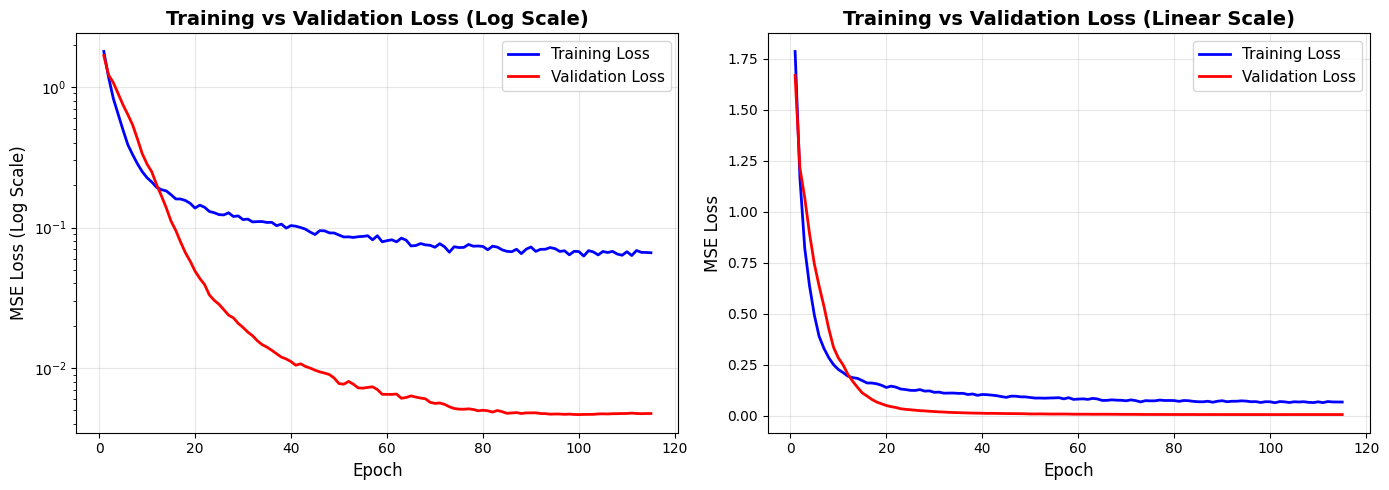


TRAINING SUMMARY
Total epochs: 115
Initial train loss: 1.786582
Final train loss: 0.066171
Initial val loss: 1.669391
Final val loss: 0.004758
Best val loss: 0.004676 (epoch 100)


In [87]:
# =============================================================================
# CELL 7b: Training and Validation Loss Curves
# =============================================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Loss curves (Log scale)
ax1 = axes[0]
epochs_range = range(1, len(train_losses) + 1)
ax1.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax1.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('MSE Loss (Log Scale)', fontsize=12)
ax1.set_title('Training vs Validation Loss (Log Scale)', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# Plot 2: Loss curves (Linear scale)
ax2 = axes[1]
ax2.plot(epochs_range, train_losses, 'b-', label='Training Loss', linewidth=2)
ax2.plot(epochs_range, val_losses, 'r-', label='Validation Loss', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('MSE Loss', fontsize=12)
ax2.set_title('Training vs Validation Loss (Linear Scale)', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print(f"\n{'='*50}")
print("TRAINING SUMMARY")
print(f"{'='*50}")
print(f"Total epochs: {len(train_losses)}")
print(f"Initial train loss: {train_losses[0]:.6f}")
print(f"Final train loss: {train_losses[-1]:.6f}")
print(f"Initial val loss: {val_losses[0]:.6f}")
print(f"Final val loss: {val_losses[-1]:.6f}")
print(f"Best val loss: {min(val_losses):.6f} (epoch {val_losses.index(min(val_losses))+1})")

In [88]:
# =============================================================================
# CELL 7b: Evaluate Model in Inference Mode (Fair Comparison)
# =============================================================================

# Evaluate both sets in inference mode (dropout OFF, batchnorm in inference mode)
train_loss_eval = autoencoder.evaluate(X_train, X_train, verbose=0)
val_loss_eval = autoencoder.evaluate(X_val, X_val, verbose=0)

print(f"{'='*60}")
print("EVALUATION IN INFERENCE MODE (Fair Comparison)")
print(f"{'='*60}")
print(f"Training loss (inference mode): {train_loss_eval:.6f}")
print(f"Validation loss (inference mode): {val_loss_eval:.6f}")
print(f"Ratio (val/train): {val_loss_eval/train_loss_eval:.2f}")

# Check if results are reasonable
if 0.8 <= val_loss_eval/train_loss_eval <= 1.5:
    print("\n✅ Train/Val loss ratio is healthy (0.8-1.5)")
elif val_loss_eval < train_loss_eval:
    print("\n⚠️  Val loss < Train loss - validation set may be 'easier' or model is regularized well")
else:
    print("\n⚠️  Val loss significantly higher - possible overfitting")

EVALUATION IN INFERENCE MODE (Fair Comparison)
Training loss (inference mode): 0.005308
Validation loss (inference mode): 0.004676
Ratio (val/train): 0.88

✅ Train/Val loss ratio is healthy (0.8-1.5)


In [89]:
# =============================================================================
# CELL 8: Compute Reconstruction Errors & Automatic Threshold
# =============================================================================

def compute_reconstruction_errors(model, data):
    """Compute per-sample reconstruction errors (MSE)."""
    reconstructed = model.predict(data, verbose=0)
    # Per-sample MSE
    errors = np.mean((data - reconstructed) ** 2, axis=1)
    return errors

# Compute errors on training and validation data
train_errors = compute_reconstruction_errors(autoencoder, X_train)
val_errors = compute_reconstruction_errors(autoencoder, X_val)

# Combine for full picture
all_errors = np.concatenate([train_errors, val_errors])

print(f"{'='*60}")
print("RECONSTRUCTION ERROR STATISTICS")
print(f"{'='*60}")
print(f"Training errors - Mean: {train_errors.mean():.6f}, Std: {train_errors.std():.6f}")
print(f"Validation errors - Mean: {val_errors.mean():.6f}, Std: {val_errors.std():.6f}")

# Method 1: Gaussian-based threshold (mean + k*std)
error_mean = train_errors.mean()
error_std = train_errors.std()
gaussian_threshold = error_mean + 3 * error_std  # 3-sigma rule (99.7%)

# Method 2: Percentile-based threshold
percentile_95 = np.percentile(train_errors, 95)
percentile_99 = np.percentile(train_errors, 99)

# Choose threshold automatically - use 95th percentile as default
# (more conservative than Gaussian for non-normal distributions)
AUTO_THRESHOLD = percentile_95

print(f"\n{'='*60}")
print("AUTOMATIC THRESHOLD SELECTION")
print(f"{'='*60}")
print(f"Gaussian threshold (mean + 3σ): {gaussian_threshold:.6f}")
print(f"95th percentile: {percentile_95:.6f}")
print(f"99th percentile: {percentile_99:.6f}")
print(f"\n🎯 SELECTED THRESHOLD (95th percentile): {AUTO_THRESHOLD:.6f}")

# Fit Gaussian to error distribution for visualization
mu, sigma = stats.norm.fit(train_errors)
print(f"\nFitted Gaussian: μ={mu:.6f}, σ={sigma:.6f}")

RECONSTRUCTION ERROR STATISTICS
Training errors - Mean: 0.005308, Std: 0.016105
Validation errors - Mean: 0.004676, Std: 0.013733

AUTOMATIC THRESHOLD SELECTION
Gaussian threshold (mean + 3σ): 0.053623
95th percentile: 0.010800
99th percentile: 0.115275

🎯 SELECTED THRESHOLD (95th percentile): 0.010800

Fitted Gaussian: μ=0.005308, σ=0.016105


In [90]:
# =============================================================================
# CELL 9: Identify Anomalies
# =============================================================================

# Identify anomalies based on threshold
train_anomalies = train_errors > AUTO_THRESHOLD
val_anomalies = val_errors > AUTO_THRESHOLD

n_train_anomalies = np.sum(train_anomalies)
n_val_anomalies = np.sum(val_anomalies)

print(f"{'='*60}")
print("ANOMALY DETECTION RESULTS")
print(f"{'='*60}")
print(f"Training set anomalies: {n_train_anomalies}/{len(train_errors)} "
      f"({100*n_train_anomalies/len(train_errors):.2f}%)")
print(f"Validation set anomalies: {n_val_anomalies}/{len(val_errors)} "
      f"({100*n_val_anomalies/len(val_errors):.2f}%)")

# Show example anomalies from validation set
print(f"\n{'='*60}")
print("EXAMPLE ANOMALIES (Top 5 by reconstruction error)")
print(f"{'='*60}")

# Get indices of top anomalies
top_anomaly_indices = np.argsort(val_errors)[-5:][::-1]

for i, idx in enumerate(top_anomaly_indices):
    print(f"\nAnomaly #{i+1}:")
    print(f"  Index: {idx}")
    print(f"  Reconstruction Error: {val_errors[idx]:.6f}")
    print(f"  Threshold: {AUTO_THRESHOLD:.6f}")
    print(f"  Above threshold by: {val_errors[idx] - AUTO_THRESHOLD:.6f}")

ANOMALY DETECTION RESULTS
Training set anomalies: 30/596 (5.03%)
Validation set anomalies: 9/150 (6.00%)

EXAMPLE ANOMALIES (Top 5 by reconstruction error)

Anomaly #1:
  Index: 71
  Reconstruction Error: 0.163628
  Threshold: 0.010800
  Above threshold by: 0.152828

Anomaly #2:
  Index: 52
  Reconstruction Error: 0.033575
  Threshold: 0.010800
  Above threshold by: 0.022775

Anomaly #3:
  Index: 99
  Reconstruction Error: 0.029055
  Threshold: 0.010800
  Above threshold by: 0.018255

Anomaly #4:
  Index: 19
  Reconstruction Error: 0.024137
  Threshold: 0.010800
  Above threshold by: 0.013337

Anomaly #5:
  Index: 91
  Reconstruction Error: 0.014066
  Threshold: 0.010800
  Above threshold by: 0.003266


In [91]:
# =============================================================================
# CELL 11: Summary & Anomaly Detection Function
# =============================================================================

def detect_anomaly(model, scaler, new_data, threshold):
    """
    Detect anomalies in new data using the trained autoencoder.
    
    Args:
        model: Trained autoencoder model (Keras)
        scaler: Fitted StandardScaler
        new_data: numpy array or pandas DataFrame of new samples
        threshold: Reconstruction error threshold
    
    Returns:
        dict with errors, is_anomaly flags, and detailed results
    """
    # Handle DataFrame input
    if isinstance(new_data, pd.DataFrame):
        new_data = new_data.values
    
    # Normalize
    normalized = scaler.transform(new_data)
    
    # Get reconstruction errors
    reconstructed = model.predict(normalized, verbose=0)
    errors = np.mean((normalized - reconstructed) ** 2, axis=1)
    
    is_anomaly = errors > threshold
    
    return {
        'errors': errors,
        'is_anomaly': is_anomaly,
        'n_anomalies': np.sum(is_anomaly),
        'threshold': threshold
    }

# Print final summary
print(f"\n{'='*60}")
print("FINAL SUMMARY")
print(f"{'='*60}")
print(f"Framework: TensorFlow {tf.__version__}")
print(f"Input features: {input_dim}")
print(f"Latent dimension: {latent_dim}")
print(f"Model parameters: {total_params:,}")
print(f"Training epochs: {len(train_losses)}")
print(f"Final training loss: {train_losses[-1]:.6f}")
print(f"Final validation loss: {val_losses[-1]:.6f}")
print(f"\n🎯 Anomaly threshold: {AUTO_THRESHOLD:.6f}")
print(f"Training anomalies: {n_train_anomalies} ({100*n_train_anomalies/len(train_errors):.2f}%)")
print(f"Validation anomalies: {n_val_anomalies} ({100*n_val_anomalies/len(val_errors):.2f}%)")
print(f"{'='*60}")

print("\n✅ Autoencoder ready for anomaly detection!")
print("Use detect_anomaly(autoencoder, scaler, new_data, AUTO_THRESHOLD) for inference.")


FINAL SUMMARY
Framework: TensorFlow 2.19.0
Input features: 15
Latent dimension: 8
Model parameters: 7,543
Training epochs: 115
Final training loss: 0.066171
Final validation loss: 0.004758

🎯 Anomaly threshold: 0.010800
Training anomalies: 30 (5.03%)
Validation anomalies: 9 (6.00%)

✅ Autoencoder ready for anomaly detection!
Use detect_anomaly(autoencoder, scaler, new_data, AUTO_THRESHOLD) for inference.


In [92]:
# =============================================================================
# CELL 12: Test Anomaly Detection with Realistic Synthetic Anomalies
# =============================================================================

print("="*60)
print("TESTING ANOMALY DETECTION")
print("="*60)
print("\n📌 Note: All training data is NORMAL (no real anomalies)")
print("   We'll create synthetic anomalies to test the model\n")

# Test 1: Normal samples (should be classified as normal)
print("-"*50)
print("TEST 1: Normal samples (from validation set)")
print("-"*50)
sample_normal = X_val[:5]
result_normal = detect_anomaly(autoencoder, scaler, sample_normal, AUTO_THRESHOLD)
for i, (err, is_anom) in enumerate(zip(result_normal['errors'], result_normal['is_anomaly'])):
    status = "🔴 ANOMALY" if is_anom else "🟢 Normal"
    print(f"  Sample {i+1}: Error={err:.6f} | {status}")

# Test 2: Sensor Drift (gradual offset in joint values)
print("\n" + "-"*50)
print("TEST 2: Sensor Drift Anomaly (offset in joint readings)")
print("-"*50)
drift_data = X_val[:5].copy()
drift_data[:, :6] += 2.0  # Add offset to joint angle columns (first 6 features typically)
result_drift = detect_anomaly(autoencoder, scaler, drift_data, AUTO_THRESHOLD)
for i, (err, is_anom) in enumerate(zip(result_drift['errors'], result_drift['is_anomaly'])):
    status = "🔴 ANOMALY" if is_anom else "🟢 Normal"
    print(f"  Sample {i+1}: Error={err:.6f} | {status}")
print(f"  Detected: {result_drift['n_anomalies']}/5 as anomalies")

# Test 3: Joint Stuck (velocity near zero while position changes)
print("\n" + "-"*50)
print("TEST 3: Spike Anomaly (sudden large values)")
print("-"*50)
spike_data = X_val[:5].copy()
spike_data[:, 0] += 5.0  # Large spike in first feature
result_spike = detect_anomaly(autoencoder, scaler, spike_data, AUTO_THRESHOLD)
for i, (err, is_anom) in enumerate(zip(result_spike['errors'], result_spike['is_anomaly'])):
    status = "🔴 ANOMALY" if is_anom else "🟢 Normal"
    print(f"  Sample {i+1}: Error={err:.6f} | {status}")
print(f"  Detected: {result_spike['n_anomalies']}/5 as anomalies")

# Test 4: Random Noise (complete random data)
print("\n" + "-"*50)
print("TEST 4: Random Noise (completely random values)")
print("-"*50)
random_data = np.random.randn(5, X_val.shape[1]) * 3  # Random data
result_random = detect_anomaly(autoencoder, scaler, random_data, AUTO_THRESHOLD)
for i, (err, is_anom) in enumerate(zip(result_random['errors'], result_random['is_anomaly'])):
    status = "🔴 ANOMALY" if is_anom else "🟢 Normal"
    print(f"  Sample {i+1}: Error={err:.6f} | {status}")
print(f"  Detected: {result_random['n_anomalies']}/5 as anomalies")

# Summary
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"Normal samples detected as anomalies: {result_normal['n_anomalies']}/5")
print(f"Drift anomalies detected: {result_drift['n_anomalies']}/5")
print(f"Spike anomalies detected: {result_spike['n_anomalies']}/5")  
print(f"Random noise detected: {result_random['n_anomalies']}/5")
print(f"\n🎯 Threshold used: {AUTO_THRESHOLD:.6f}")

TESTING ANOMALY DETECTION

📌 Note: All training data is NORMAL (no real anomalies)
   We'll create synthetic anomalies to test the model

--------------------------------------------------
TEST 1: Normal samples (from validation set)
--------------------------------------------------
  Sample 1: Error=27.626982 | 🔴 ANOMALY
  Sample 2: Error=26.950776 | 🔴 ANOMALY
  Sample 3: Error=13.768637 | 🔴 ANOMALY
  Sample 4: Error=36.341273 | 🔴 ANOMALY
  Sample 5: Error=34.116949 | 🔴 ANOMALY

--------------------------------------------------
TEST 2: Sensor Drift Anomaly (offset in joint readings)
--------------------------------------------------
  Sample 1: Error=48.789602 | 🔴 ANOMALY
  Sample 2: Error=50.065109 | 🔴 ANOMALY
  Sample 3: Error=32.712764 | 🔴 ANOMALY
  Sample 4: Error=50.731736 | 🔴 ANOMALY
  Sample 5: Error=60.611477 | 🔴 ANOMALY
  Detected: 5/5 as anomalies

--------------------------------------------------
TEST 3: Spike Anomaly (sudden large values)
-------------------------------

In [93]:
# =============================================================================
# CELL 13: Test Single Point - Easy Function
# =============================================================================

# Calculate different thresholds
THRESHOLD_95 = np.percentile(train_errors, 95)  # ~5% false positive rate
THRESHOLD_99 = np.percentile(train_errors, 99)  # ~1% false positive rate
THRESHOLD_MAX = np.max(train_errors)            # Maximum seen in training (0% false positive on training)

print("Available Thresholds:")
print(f"  95th percentile: {THRESHOLD_95:.6f} (5% of normal data above this)")
print(f"  99th percentile: {THRESHOLD_99:.6f} (1% of normal data above this)")
print(f"  Max training error: {THRESHOLD_MAX:.6f} (safest - 0% false positive on training)")

# Use 99th percentile as default (more conservative)
THRESHOLD = THRESHOLD_99

def check_point(point, threshold=None):
    """
    Check if a single point is normal or anomaly.
    
    Args:
        point: list or array of feature values (15 features)
        threshold: custom threshold (optional, default=99th percentile)
    
    Returns:
        dict with error, is_anomaly, and status
    """
    if threshold is None:
        threshold = THRESHOLD
    
    point = np.array(point).reshape(1, -1)
    
    # Normalize
    point_normalized = scaler.transform(point)
    
    # Get reconstruction
    reconstructed = autoencoder.predict(point_normalized, verbose=0)
    
    # Calculate error
    error = np.mean((point_normalized - reconstructed) ** 2)
    
    # Check if anomaly
    is_anomaly = error > threshold
    
    # Print result
    status = "🔴 ANOMALY" if is_anomaly else "🟢 NORMAL"
    print(f"{'='*50}")
    print(f"Point Analysis Result")
    print(f"{'='*50}")
    print(f"Reconstruction Error: {error:.6f}")
    print(f"Threshold used: {threshold:.6f}")
    print(f"Status: {status}")
    
    # Show distance from threshold
    if is_anomaly:
        print(f"Above threshold by: {error - threshold:.6f}")
    else:
        print(f"Below threshold by: {threshold - error:.6f}")
    print(f"{'='*50}")
    
    return {
        'error': error,
        'threshold': threshold,
        'is_anomaly': is_anomaly,
        'status': 'ANOMALY' if is_anomaly else 'NORMAL'
    }

print(f"\n🎯 Default threshold set to 99th percentile: {THRESHOLD:.6f}")
print("\nUsage:")
print("  check_point([Q1,Q2,Q3,Q4,Q5,Q6,dQ1,dQ2,dQ3,dQ4,dQ5,dQ6,X,Y,Z])")
print("  check_point(point, threshold=THRESHOLD_MAX)  # Use max threshold")

Available Thresholds:
  95th percentile: 0.010800 (5% of normal data above this)
  99th percentile: 0.115275 (1% of normal data above this)
  Max training error: 0.198625 (safest - 0% false positive on training)

🎯 Default threshold set to 99th percentile: 0.115275

Usage:
  check_point([Q1,Q2,Q3,Q4,Q5,Q6,dQ1,dQ2,dQ3,dQ4,dQ5,dQ6,X,Y,Z])
  check_point(point, threshold=THRESHOLD_MAX)  # Use max threshold


In [94]:
check_point([-2.18714329657152,-1.41244245106878,-2.14557385235776,-0.689062265502895,1.82022805876869,-0.456954226750132,0.110877275550077,0.273516356310998,-0.287714432109106,0.039311166925951,-0.0498081741992509,0.102193693094634,0.328457793617333,0.455617189025004,0.162976575398132])

Point Analysis Result
Reconstruction Error: 0.054184
Threshold used: 0.115275
Status: 🟢 NORMAL
Below threshold by: 0.061091


{'error': np.float64(0.05418365466630299),
 'threshold': np.float64(0.11527480414817567),
 'is_anomaly': np.False_,
 'status': 'NORMAL'}

In [95]:
check_point([-2.18714329657152,-1.41244245106878,-2.14557385235776,-0.689062265502895,1.82022805876869,-0.456954226750132,0.110877275550077,0.273516356310998,-0.287714432109106,0.039311166925951,-0.0498081741992509,0.102193693094634,0.328457793617333,0.455617189025004,0.162976575398132] + np.random.normal(0, 0.1, 15))  # Add large noise to simulate anomaly

Point Analysis Result
Reconstruction Error: 0.267253
Threshold used: 0.115275
Status: 🔴 ANOMALY
Above threshold by: 0.151978


{'error': np.float64(0.2672532896988405),
 'threshold': np.float64(0.11527480414817567),
 'is_anomaly': np.True_,
 'status': 'ANOMALY'}